In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

In [2]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [6]:
from datasets import Dataset
from PIL import Image
from pathlib import Path
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from numpy import asarray

# Define the root directory where your instrument datasets are located
root = r"/content/drive/MyDrive/MICCAI 2017 Robotic Instrument Segmentation Dataset/data/cropped_train"  # Update this with the actual root path

# Initialize lists to store images and binary masks
images = []
masks = []

# Loop through each instrument dataset
for instrument_id in tqdm(range(1, 3)):
    folder_path = os.path.join(root, 'instrument_dataset_' + str(instrument_id), 'images')

    # List all image files in the current folder
    image_files = list(Path(folder_path).glob('*'))

    # Loop through image files and load images and corresponding masks
    for image_file in tqdm(image_files):
        # Load image
        image = Image.open(image_file)
        image= image.resize((256,256))

        # Load corresponding binary mask
        mask_file = os.path.join(root, 'instrument_dataset_' + str(instrument_id), 'binary_masks', image_file.stem + '.png')
        mask = Image.open(mask_file)
        mask= mask.resize((256,256))

        # Append the image and mask to the lists
        images.append(image)
        masks.append(mask)

# Convert the lists to Dataset format
dataset_dict = {
    "image": images,
    "label": masks,
}

# Create the dataset using the datasets.Dataset class
custom_dataset = Dataset.from_dict(dataset_dict)


100%|██████████| 2/2 [02:25<00:00, 72.91s/it]


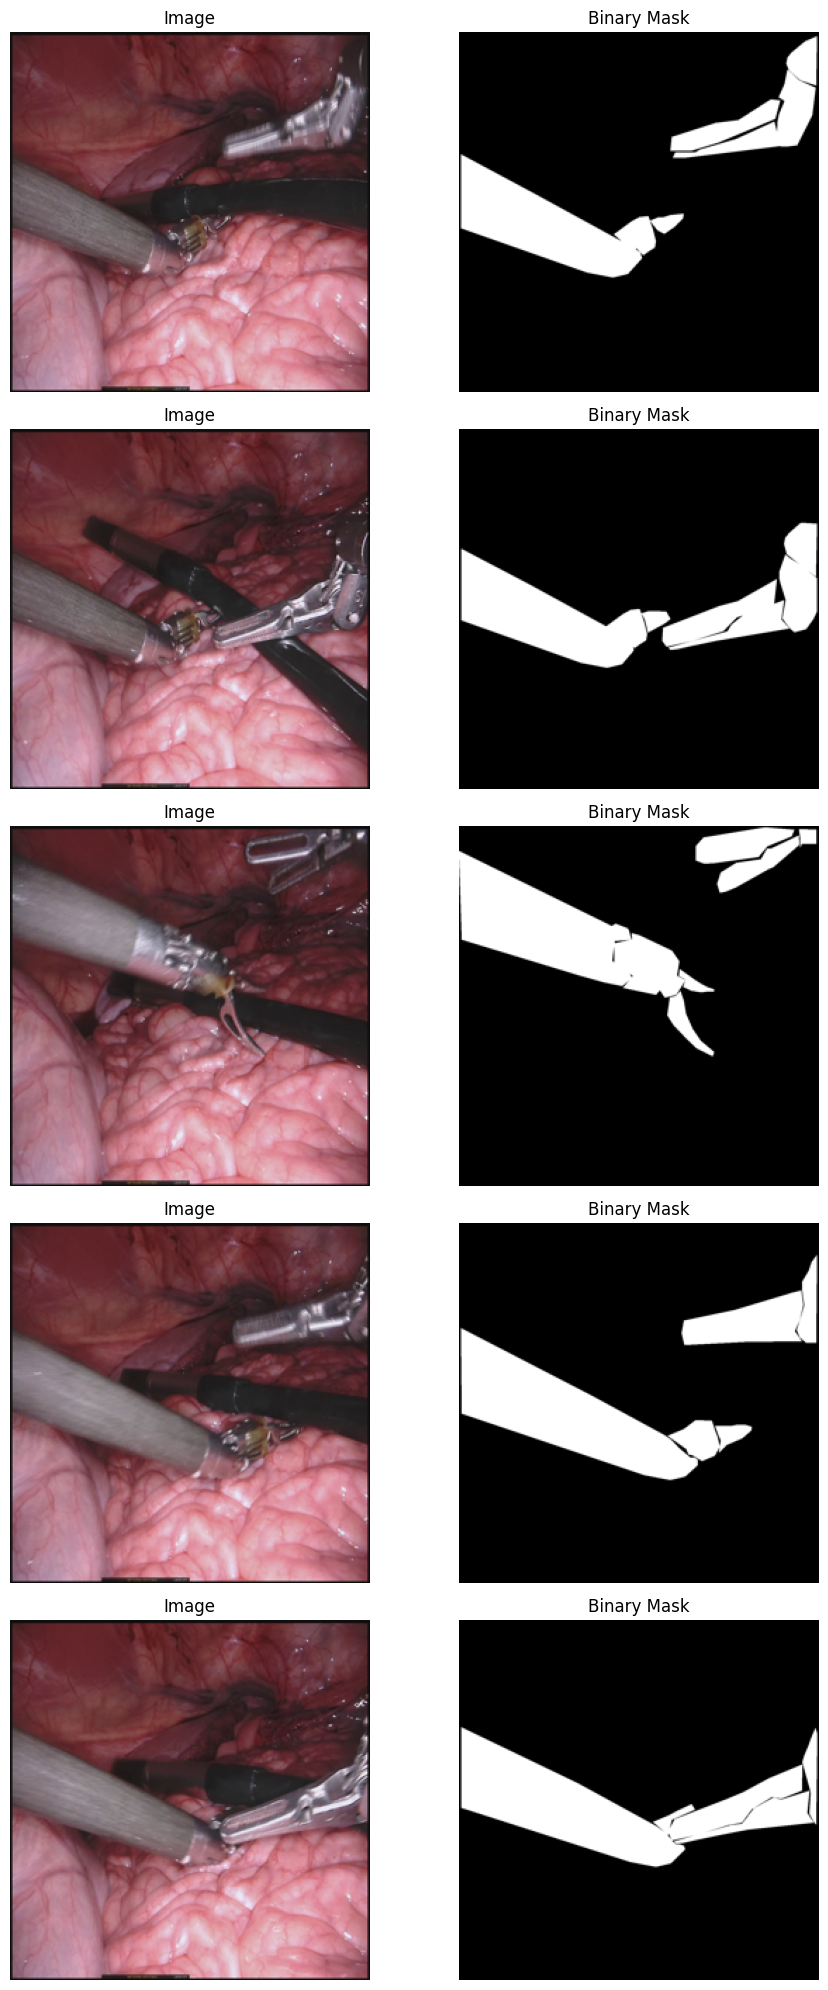

In [13]:
# Visualize some examples
num_examples_to_visualize = 5

fig, axes = plt.subplots(num_examples_to_visualize, 2, figsize=(10, 20))
for i in range(num_examples_to_visualize):
    example_idx = i * 2
    image, binary_mask = (dataset_dict['image'][example_idx],dataset_dict['label'][example_idx])

    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(binary_mask, cmap='gray')
    axes[i, 1].set_title('Binary Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [15]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [16]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [17]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=custom_dataset, processor=processor)

In [18]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [19]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [20]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [21]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [22]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [23]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [24]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 225/225 [03:36<00:00,  1.04it/s]


EPOCH: 0
Mean loss: 0.9921840394867791


100%|██████████| 225/225 [03:36<00:00,  1.04it/s]


EPOCH: 1
Mean loss: 0.9919713513056437


100%|██████████| 225/225 [03:36<00:00,  1.04it/s]


EPOCH: 2
Mean loss: 0.9919707009527419


100%|██████████| 225/225 [03:36<00:00,  1.04it/s]


EPOCH: 3
Mean loss: 0.991970599492391


100%|██████████| 225/225 [03:36<00:00,  1.04it/s]


EPOCH: 4
Mean loss: 0.991970551278856


100%|██████████| 225/225 [03:36<00:00,  1.04it/s]


EPOCH: 5
Mean loss: 0.9919704998864068


100%|██████████| 225/225 [03:37<00:00,  1.04it/s]


EPOCH: 6
Mean loss: 0.9919704325993856


100%|██████████| 225/225 [03:36<00:00,  1.04it/s]


EPOCH: 7
Mean loss: 0.991970391538408


100%|██████████| 225/225 [03:36<00:00,  1.04it/s]


EPOCH: 8
Mean loss: 0.9919704103469849


100%|██████████| 225/225 [03:36<00:00,  1.04it/s]

EPOCH: 9
Mean loss: 0.9919704087575276


In [25]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "model_checkpoint.pth")

#Inference

In [26]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [27]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/model_checkpoint.pth"))

<All keys matched successfully>

In [28]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [49]:
test_image = np.array(dataset_dict["image"][2])
test_image.shape

(256, 256, 3)

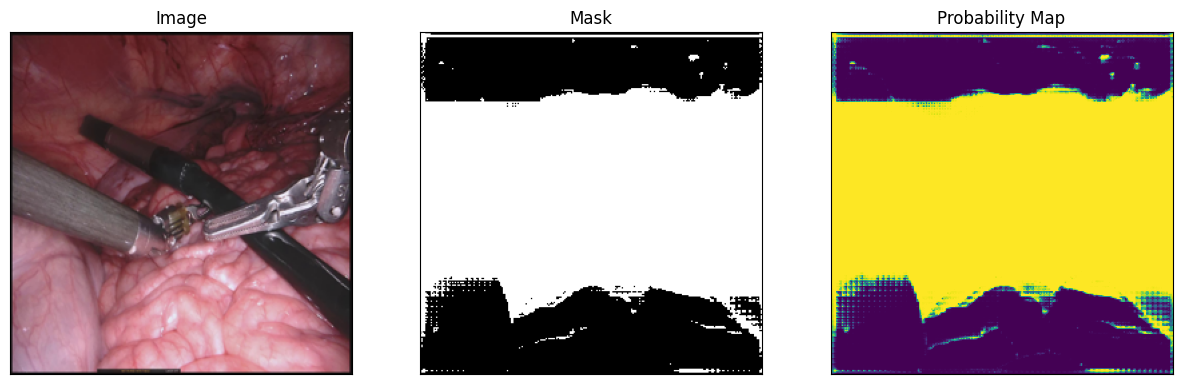

In [52]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt


# load image
test_image = np.array(dataset_dict["image"][2])

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset_dict["label"][2])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
